In [51]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder,SingleGalsimGalaxyPrior,UniformGalsimGalaxiesPrior
from bliss.datasets.galsim_galaxies import GalsimBlends


In [20]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
def _add_noise_and_background(image: Tensor, background: Tensor) -> Tensor:
    image_with_background = image + background
    noise = image_with_background.sqrt() * torch.randn_like(image_with_background)
    return image_with_background + noise

def load_psf_from_file(psf_image_file: str, pixel_scale: float) -> galsim.GSObject:
    """Return normalized PSF galsim.GSObject from numpy psf_file."""
    assert Path(psf_image_file).suffix == ".npy"
    psf_image = np.load(psf_image_file)
    assert len(psf_image.shape) == 3 and psf_image.shape[0] == 1
    psf_image = galsim.Image(psf_image[0], scale=pixel_scale)
    return galsim.InterpolatedImage(psf_image).withFlux(1.0)

def _sample_n_sources(max_n_sources) -> int:
    return int(torch.randint(1, max_n_sources + 1, (1,)).int().item())

def _uniform(a, b, n_samples=1) -> Tensor:
    # uses pytorch to return a single float ~ U(a, b)
    return (a - b) * torch.rand(n_samples) + b

class CoaddUniformGalsimGalaxiesPrior(UniformGalsimGalaxiesPrior):
    def __init__(
        self,
        single_galaxy_prior: SingleGalsimGalaxyPrior,
        max_n_sources: int,
        max_shift: float,
        num_dithers: int,
    ):
        super().__init__(
            single_galaxy_prior,
            max_n_sources,
            max_shift,
        )
        
    def sample(self) -> Dict[str, Tensor]:
        """Returns a single batch of source parameters."""
        n_sources = _sample_n_sources(self.max_n_sources)

        params = torch.zeros(self.max_n_sources, self.dim_latents)
        params[:n_sources, :] = self.single_galaxy_prior.sample(n_sources)

        locs = torch.zeros(self.max_n_sources, 2)
        locs[:n_sources, 0] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5
        locs[:n_sources, 1] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5

        # for now, galaxies only
        galaxy_bools = torch.zeros(self.max_n_sources, 1)
        galaxy_bools[:n_sources, :] = 1
        star_bools = torch.zeros(self.max_n_sources, 1)

        dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(num_dithers)]

        return {
            "n_sources": torch.tensor(n_sources),
            "galaxy_params": params,
            "locs": locs,
            "galaxy_bools": galaxy_bools,
            "star_bools": star_bools,
            "dithers": dithers,
        }

class CoaddSingleGalaxyDecoder(SingleGalsimGalaxyDecoder):
    def __init__(
        self,
        slen: int,
        n_bands: int,
        pixel_scale: float,
    #    psf_image_file: str,
     ) -> None:
        assert n_bands == 1, "Only 1 band is supported"
        self.slen = slen
        self.n_bands = 1
        self.pixel_scale = pixel_scale
    #    self.psf = load_psf_from_file(psf_image_file, self.pixel_scale)
        
    def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0,0) if offset is None else offset
        dithers = (0,0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1,2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

class FullCatalogDecoder:
    def __init__(
        self, single_galaxy_decoder: CoaddSingleGalaxyDecoder, slen: int, bp: int
    ) -> None:
        self.single_decoder = single_galaxy_decoder
        self.slen = slen
        self.bp = bp
        assert self.slen + 2 * self.bp >= self.single_decoder.slen

    def __call__(self, full_cat: FullCatalog):
        return self.render_catalog(full_cat, self.single_decoder.psf)

    def render_catalog(self, full_cat: FullCatalog, psf: galsim.GSObject, dithers: Optional[Tensor]):
        size = decoder.slen + 2 * bp
        full_plocs = full_catalog.plocs
        b, max_n_sources, _ = full_plocs.shape

        image = torch.zeros(len(dithers), 1, size, size)
        image0 = torch.zeros(1, size, size)
        noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
        noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

        n_sources = int(full_catalog.n_sources[0].item())
        galaxy_params = full_catalog["galaxy_params"][0]
        plocs = full_plocs[0]

        for ii in range(n_sources):
            offset_x = plocs[ii][1] + bp - size / 2
            offset_y = plocs[ii][0] + bp - size / 2
            offset = torch.tensor([offset_x, offset_y])
            centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
            uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset)
            uncentered_dithered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
            noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
            noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
            image0 += uncentered
            image += uncentered_dithered
        return image, noiseless_centered, noiseless_uncentered, image0


class CoaddGalsimBlends(GalsimBlends):
    """Dataset of coadd galsim blends."""

    def __init__(self,
        prior: UniformGalsimGalaxiesPrior,
        decoder: FullCatalogDecoder,
        background: ConstantBackground,
        tile_slen: int,
        max_sources_per_tile: int,
        num_workers: int,
        batch_size: int,
        n_batches: int,
        fix_validation_set: bool = False,
        valid_n_batches: Optional[int] = None,
    ):
        super().__init__(
            prior,
            decoder,
            background,
            tile_slen,
            max_sources_per_tile,
            num_workers,
            batch_size,
            n_batches,
            fix_validation_set,
            valid_n_batches,
        )
        self.prior = prior
        self.decoder = decoder
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.background = background
        self.fix_validation_set = fix_validation_set
        self.valid_n_batches = valid_n_batches
        
        self.slen = self.decoder.slen
        self.pixel_scale = self.decoder.single_decoder.pixel_scale
        

    def _get_images(self, full_cat, dithers):
        noiseless, noiseless_centered, noiseless_uncentered = FullCatalogDecoder.render_catalog(
            full_cat, dithers
        )

        # get background and noisy image.
        background = self.background.sample((1, *noiseless.shape)).squeeze(0)
        noisy_image = _add_noise_and_background(noiseless, background)

        return noisy_image, noiseless, noiseless_centered, noiseless_uncentered, background





In [4]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [11]:
prior = instantiate(cfg.datasets.sdss_galaxies.prior) 
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
n_batches = 1
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
mprior = instantiate(cfg.models.prior)
tile_catalog = mprior.sample_prior(tile_slen=4, batch_size=3, n_tiles_h=2, n_tiles_w=2)
full_catalog = TileCatalog.to_full_params(tile_catalog)

In [12]:
# Test CUGGP
cuggp = CoaddUniformGalsimGalaxiesPrior(prior, max_n_sources, max_shift, num_dithers)


In [13]:
pixel_scale = 0.393
cuggprior = cuggp.sample() # does not work if we use galsim_blended_galaxies for prior config
n_sources = cuggprior["n_sources"]
galaxy_params = cuggprior["galaxy_params"]
locs = cuggprior["locs"]
galaxy_bools = cuggprior["galaxy_bools"]
star_bools = cuggprior["star_bools"]
dithers = cuggprior["dithers"]
offset = None
psf = decoder.psf


In [34]:
dithers

[array([-0.4811225 , -0.21159571], dtype=float32),
 array([-0.34641796, -0.29002923], dtype=float32),
 array([-0.32266533, -0.25221276], dtype=float32),
 array([-0.09234637, -0.26480418], dtype=float32)]

In [14]:
csgd = CoaddSingleGalaxyDecoder(decoder, n_bands = 1, pixel_scale = pixel_scale)
csgd.render_galaxy(galaxy_params = galaxy_params[0], slen = decoder.slen, psf = decoder.psf, offset = offset, dithers = dithers)

tensor([[[[0.2628, 0.2762, 0.2902,  ..., 0.3085, 0.2939, 0.2799],
          [0.2830, 0.2981, 0.3138,  ..., 0.3343, 0.3178, 0.3020],
          [0.3048, 0.3217, 0.3394,  ..., 0.3624, 0.3437, 0.3259],
          ...,
          [0.3060, 0.3228, 0.3403,  ..., 0.3508, 0.3328, 0.3156],
          [0.2841, 0.2990, 0.3146,  ..., 0.3236, 0.3077, 0.2924],
          [0.2638, 0.2771, 0.2909,  ..., 0.2987, 0.2846, 0.2710]]],


        [[[0.2613, 0.2745, 0.2883,  ..., 0.3065, 0.2921, 0.2781],
          [0.2814, 0.2963, 0.3118,  ..., 0.3321, 0.3158, 0.3001],
          [0.3030, 0.3198, 0.3373,  ..., 0.3600, 0.3415, 0.3238],
          ...,
          [0.3078, 0.3248, 0.3425,  ..., 0.3530, 0.3349, 0.3175],
          [0.2858, 0.3009, 0.3166,  ..., 0.3257, 0.3097, 0.2942],
          [0.2654, 0.2788, 0.2928,  ..., 0.3006, 0.2864, 0.2727]]],


        [[[0.2670, 0.2804, 0.2943,  ..., 0.2945, 0.2806, 0.2672],
          [0.2879, 0.3030, 0.3187,  ..., 0.3187, 0.3030, 0.2879],
          [0.3105, 0.3275, 0.3452,  ..

In [15]:
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(prior = prior, decoder = decoder, background = background, tile_slen = tile_slen, max_sources_per_tile = max_tile_n_sources, num_workers = num_workers, batch_size = batch_size, n_batches = n_batches)._sample_full_catalog()

In [16]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp)
fcdecoder.render_catalog(full_catalog, psf, dithers) # Do I need to change the target in config to bliss.case_study.coadd.coadd_decoder?

RuntimeError: output with shape [1, 88, 88] doesn't match the broadcast shape [1, 1, 88, 88]

In [48]:
dithers

[array([ 0.2863866, -0.2431587], dtype=float32),
 array([0.45234668, 0.29335123], dtype=float32),
 array([0.26052737, 0.14739156], dtype=float32),
 array([-0.45585835,  0.38580644], dtype=float32)]

In [17]:
total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params[0]
bulge_frac = 1 - disk_frac

disk_flux = total_flux * disk_frac
bulge_flux = total_flux * bulge_frac

components = []
if disk_flux > 0:
    b_d = a_d * disk_q
    disk_hlr_arcsecs = np.sqrt(a_d * b_d)
    disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
        q=disk_q,
        beta=beta_radians * galsim.radians,
    )
    components.append(disk)
if bulge_flux > 0:
    b_b = bulge_q * a_b
    bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
    bulge = galsim.DeVaucouleurs(
        flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
    ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
    components.append(bulge)
galaxy = galsim.Add(components)
gal_conv = galsim.Convolution(galaxy, psf)
offset = (0,0) if offset is None else offset
dithers = (0,0) if dithers is None else dithers
shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
shift = shift.reshape(1,2) if len(shift) == 2 else shift
images = []
for i in shift:
    image = gal_conv.drawImage(
        nx=slen, ny=slen, method="auto", scale=pixel_scale, offset=i
    )
    image = image.array
    images.append(image)
torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


tensor([[[[0.6450, 0.6866, 0.7302,  ..., 0.7836, 0.7379, 0.6940],
          [0.7072, 0.7555, 0.8065,  ..., 0.8685, 0.8147, 0.7633],
          [0.7753, 0.8314, 0.8910,  ..., 0.9631, 0.8998, 0.8397],
          ...,
          [0.7746, 0.8299, 0.8884,  ..., 0.9296, 0.8688, 0.8113],
          [0.7065, 0.7541, 0.8042,  ..., 0.8384, 0.7868, 0.7375],
          [0.6444, 0.6854, 0.7281,  ..., 0.7566, 0.7127, 0.6705]]],


        [[[0.6403, 0.6814, 0.7244,  ..., 0.7771, 0.7319, 0.6886],
          [0.7020, 0.7497, 0.8000,  ..., 0.8612, 0.8081, 0.7574],
          [0.7696, 0.8251, 0.8839,  ..., 0.9550, 0.8924, 0.8332],
          ...,
          [0.7804, 0.8364, 0.8957,  ..., 0.9373, 0.8758, 0.8176],
          [0.7119, 0.7600, 0.8107,  ..., 0.8454, 0.7931, 0.7432],
          [0.6493, 0.6907, 0.7341,  ..., 0.7629, 0.7183, 0.6757]]],


        [[[0.6581, 0.6996, 0.7430,  ..., 0.7394, 0.6962, 0.6549],
          [0.7231, 0.7716, 0.8224,  ..., 0.8175, 0.7669, 0.7187],
          [0.7947, 0.8511, 0.9108,  ..

In [18]:
size = decoder.slen + 2 * bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
    noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
    image += uncentered

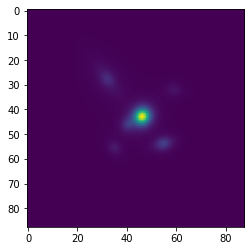

In [21]:
plt.imshow(image[2].reshape(image[2].shape[1],image[2].shape[2]).numpy())

In [69]:
centered.shape

torch.Size([4, 1, 88, 88])

In [71]:
noiseless_centered.shape

torch.Size([6, 4, 88, 88])

In [72]:
image.shape

torch.Size([4, 1, 88, 88])

In [22]:
image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset)
    uncentered_dithered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
    noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
    image0 += uncentered
    image += uncentered_dithered

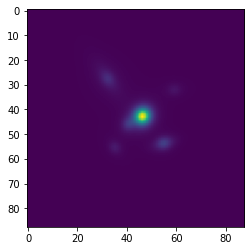

In [23]:
plt.imshow(image0[:].reshape(image0[:].shape[2],image0[:].shape[3]).numpy())

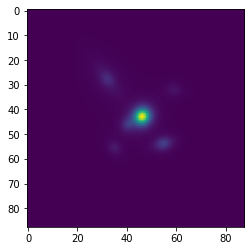

In [24]:
plt.imshow(image[2].reshape(image[2].shape[1],image[2].shape[2]).numpy())

In [40]:
i0 = galsim.Image(np.array(image0[:].reshape(88,88)), wcs=galsim.PixelScale(pixel_scale))
i1 = galsim.Image(np.array(image[:][0].reshape(88,88)))

In [41]:
i0

galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=88, ymin=1, ymax=88), array=
array([[0.08272244, 0.09300385, 0.10456953, ..., 0.01125182, 0.01102378,
        0.01079921],
       [0.08105282, 0.09132911, 0.10296295, ..., 0.01276185, 0.0125016 ,
        0.01224473],
       [0.07930537, 0.0895243 , 0.10115696, ..., 0.01448483, 0.01418667,
        0.01389174],
       ...,
       [0.00234879, 0.0025106 , 0.00268801, ..., 0.02021956, 0.01892692,
        0.01770169],
       [0.0021944 , 0.00234246, 0.00250437, ..., 0.0201644 , 0.01891153,
        0.01771894],
       [0.00205302, 0.0021885 , 0.00233656, ..., 0.02008204, 0.01887209,
        0.01771483]], dtype=float32), wcs=galsim.PixelScale(0.393))

In [44]:
from bliss.models.decoder import get_mgrid
def align_single_exposures(img0, img1, slen, dithers):
    img0 = galsim.Image(np.array(img0), wcs=galsim.PixelScale(pixel_scale))
    wcs0 = img0.wcs
    images = img1

    sgrid = (get_mgrid(slen) - (-1))/(1-(-1)) * (slen)
    grid_x = wcs0.xyTouv(np.array(sgrid.reshape(slen*slen,2)[:,0]), np.array(sgrid.reshape(slen*slen,2)[:,1]))[0]
    grid_y = wcs0.xyTouv(np.array(sgrid.reshape(slen*slen,2)[:,0]), np.array(sgrid.reshape(slen*slen,2)[:,1]))[1]

    grid = torch.empty(size=(0, 2))
    for i in dithers:
        wcs1 = galsim.OffsetWCS(scale = 0.393, origin = galsim.PositionD(i))
        x, y = wcs1.uvToxy(grid_x,grid_y)
        x_grid = (x/slen) * (1-(-1)) + (-1)
        y_grid = (y/slen) * (1-(-1)) + (-1)
        grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)

    iplots = []
    input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
    grids = grid.reshape(len(dithers),1,slen*slen,2).float()
    iplots.append(F.grid_sample(input, grids, align_corners = False))
    
    tenplot = torch.tensor(iplots[:][0])
    crop_images = []
    for i in range(tenplot.shape[0]):
        im = np.array(tenplot[i].reshape(slen,slen))
        crop_im = im[1:slen-1, 1:slen-1]
        crop_images.append(crop_im)
    return crop_images

In [49]:
image[:].shape

torch.Size([4, 1, 88, 88])

In [54]:
torch.tensor(align_single_exposures(image0[:].reshape(88,88), image, size, dithers)).shape

/tmp/ipykernel_1798461/3117052429.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
/tmp/ipykernel_1798461/3117052429.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tenplot = torch.tensor(iplots[:][0])


torch.Size([4, 86, 86])